In [1]:
import wandb
import pandas as pd
import numpy as np
from scipy.stats import binomtest

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
alg_names = {
    "vmcts": "VerMCTS (ours)",
    "whole": "Whole sampling",
    "reflexion": "Reflexion",
    "rollout": "MCTS rollout",
}
colors = sns.color_palette("Set1", n_colors=4, ) # desat=.5)
color_names = dict(zip(alg_names.keys(), colors))

In [3]:
api = wandb.Api()
runs = api.runs(path="seas/vmcts")

In [4]:
whole_df = pd.DataFrame()

whole_groups = [
    "whole-coqchecks6-2",
]

whole_keys = ["n_tokens", "is_solution", "score_sign", "time"]

keys = whole_keys
for run in runs:
    if run.group in whole_groups:
        # if "repeat" in run.config["problem_name"] and "repeat" not in  run.group:
        #     continue
        history = run.scan_history(keys)

    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["alg"] = "whole"
        run_dict["temp"] = run.config["model_arg_temp"]
        run_dict["discovery_factor"] = run.config["discovery_factor"]
        run_dict["widen_policy_value"] = run.config["widen_policy_value"]
        run_dict["seed"] = run.config["seed"]
        run_dict["problem_name"] = run.config["problem_name"]
        
        for key in keys:
            run_dict[key] = []

        for row in history:
            for key in keys:
                run_dict[key].append(row[key])
        
        for key in keys:
            run_dict[key] = np.array(run_dict[key])

        run_df = pd.DataFrame(run_dict)
        whole_df = pd.concat([whole_df, run_df])

In [5]:
len(whole_df)

3575

In [6]:
whole_df["problem_name"].value_counts().min()

92

In [7]:
tree_df = pd.DataFrame()

tree_groups = [
            "vmcts-coqchecks6-3",
            "reflexion-coqchecks6-1",
            "rollout-coqchecks6-1",
               ]

tree_keys = [
    "final/n_tokens",
    # "final/width",
    # "final/depth",
    # "final/total_nodes",
    # "final/max_value",
    # "final/min_value",
]

keys = tree_keys
for run in runs:
    if run.group in tree_groups:
        # if "repeat" in run.config["problem_name"] and "repeat" not in run.group and not "rollout" in run.group:
        #     continue
        history = run.summary
    
        run_dict = {}
        run_dict["id"] = run.id
        run_dict["group"] = run.group
        run_dict["alg"] = run.group.split("-")[0]
        run_dict["discovery_factor"] = run.config["discovery_factor"]
        run_dict["widen_policy_value"] = run.config["widen_policy_value"]
        run_dict["seed"] = run.config["seed"]
        run_dict["model_arg_temp"] = run.config["model_arg_temp"]
        run_dict["problem_name"] = run.config["problem_name"]

        if any([key not in history for key in keys]):
            continue
        for key in keys:
            run_dict[key] = history[key]

        run_df = pd.DataFrame(run_dict, index=[0])
        tree_df = pd.concat([tree_df, run_df])

In [8]:
len(tree_df)

1380

In [9]:
def confidence_interval(successes, trials=100):
    ci = binomtest(successes, trials).proportion_ci(confidence_level=0.95, method="wilson")
    return ci.low, ci.high

def compute_whole_pass_at_t_and_ci(df, t):
    prob_passes = {}
    for problem in df["problem_name"].unique():
        passes = []
        problem_df = df[df["problem_name"] == problem]
        token_counter = 0
        for row in problem_df.iterrows():
            token_counter += row[1]["n_tokens"]
            if token_counter > t:
                passes.append(0)
                token_counter = 0
            elif row[1]["is_solution"]:
                passes.append(1)
                token_counter = 0
        prob_passes[problem] = passes

    # Normalize by problem
    min_prob_count = min([len(prob_passes[problem]) for problem in prob_passes])
    # print("Min count: ", min_prob_count)
    shortened_passes = {problem: passes[:min_prob_count] for problem, passes in prob_passes.items()}
    passes = [p for passes in shortened_passes.values() for p in passes]

    total_passes = np.sum(passes)
    total_trials = len(passes)
    pass_at_t = total_passes / total_trials
    low, high = confidence_interval(total_passes, total_trials)
    return pass_at_t, low, high

def compute_pass_at_t_and_ci(df, t):
    passes = (df[f"final/n_tokens"] <= t).sum()
    total = len(df)
    pass_at_t = passes / total
    low, high = confidence_interval(passes, total)
    return pass_at_t, low, high

In [10]:
def plot_pass(df, ax):
    ts = np.arange(0, 5100, 100)
    success_rates, lows, highs = [], [], []
    for t in ts:
        if "whole" in df["alg"].iloc[0]:
            success_rate, low, high = compute_whole_pass_at_t_and_ci(df, t)
        else:
            success_rate, low, high = compute_pass_at_t_and_ci(df, t)
        success_rates.append(success_rate)
        lows.append(low)
        highs.append(high)
    alg = df["alg"].iloc[0]
    ax.plot(ts, success_rates, label=alg_names[alg], color=color_names[alg])
    ax.fill_between(ts, lows, highs, alpha=0.3, color=color_names[alg])
    ax.set_ylim(0,1)

# Plot all algs per problem

In [11]:
problems = tree_df["problem_name"].unique()
problems

array(['problem_fact_coq_check', 'problem_bst_coq_check',
       'problem_lights_more_coq_check', 'problem_opt0_coq_check',
       'problem_repeat_coq_check', 'problem_opt0_opt_coq_check'],
      dtype=object)

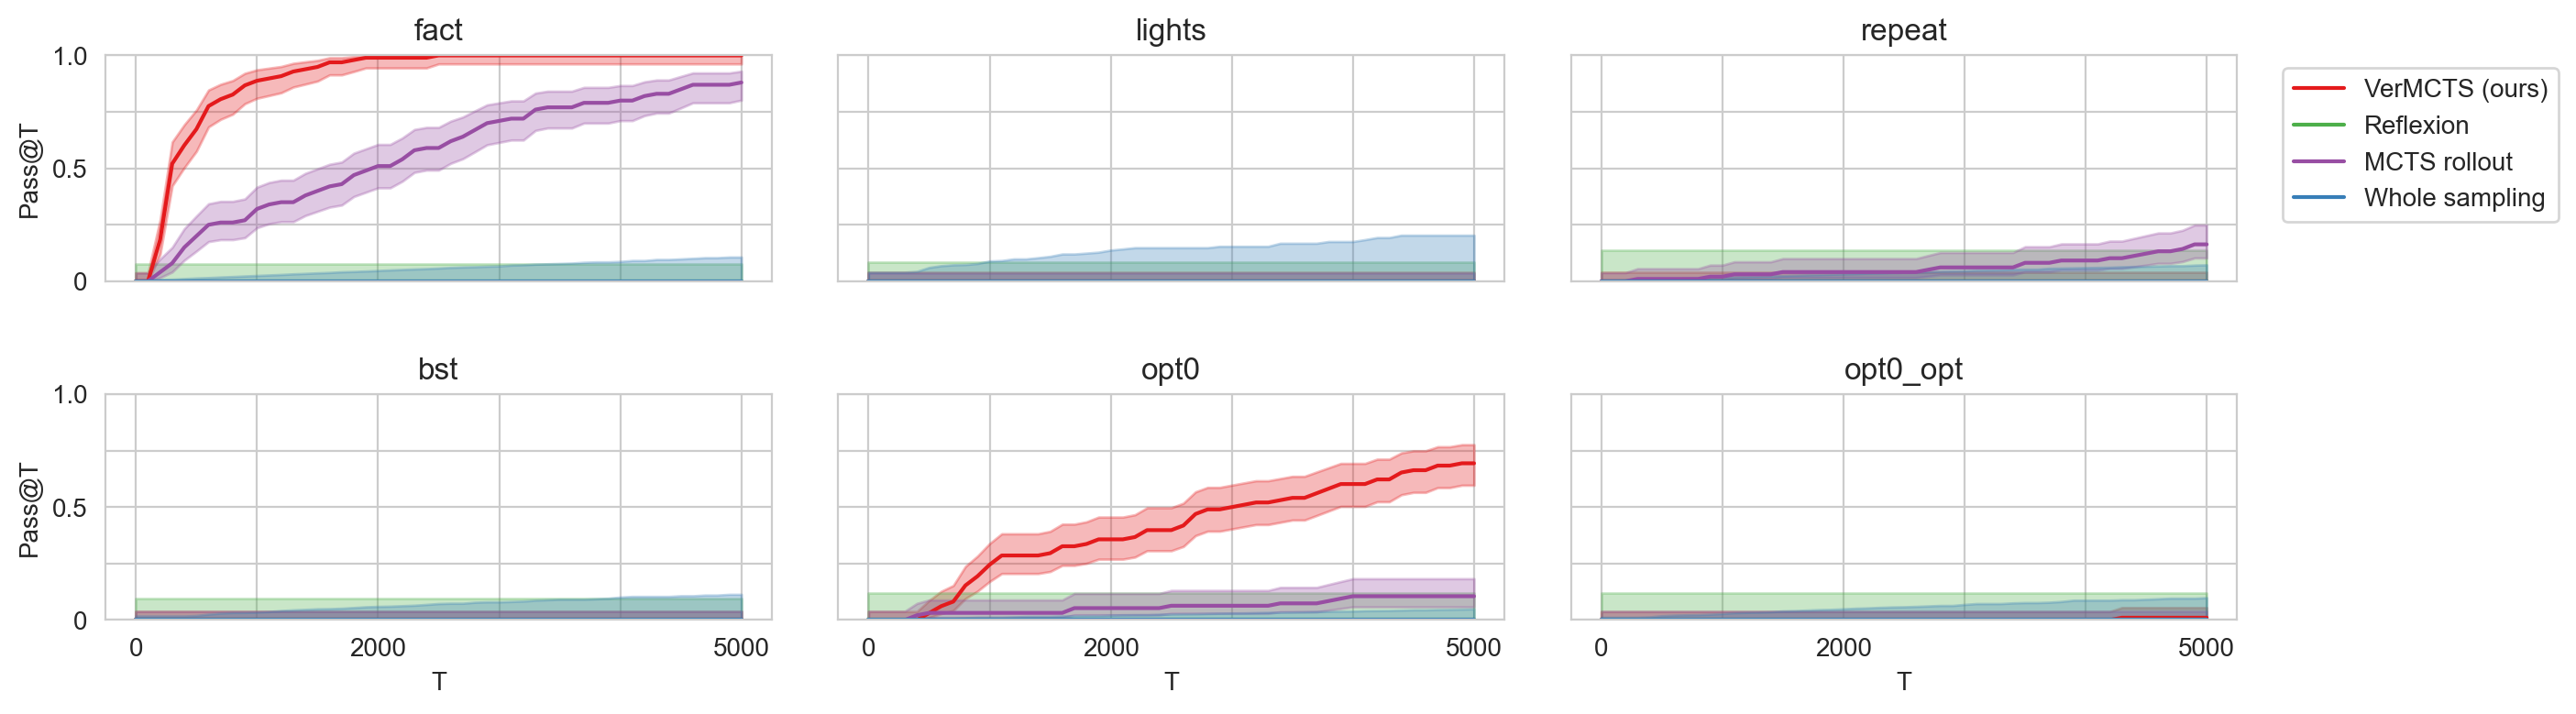

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(15, 4), dpi=200)
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.1)
sns.set_style("whitegrid")

for i, problem in enumerate(problems):
    ax = axs[i%2, i//2]

    
    for alg in alg_names:
        if alg == "whole":
            continue
        select_df = tree_df[tree_df["alg"] == alg]
        select_df = select_df[select_df["problem_name"] == problem]
        if len(select_df) == 0:
            continue
        plot_pass(select_df, ax)

    select_df = whole_df[whole_df["problem_name"] == problem]
    plot_pass(select_df, ax)
    
    ax.set_title(problem.replace("problem_", "").replace("_coq_check", "").replace("_more", ""))
    if i % 2 == 1:
        ax.set_xlabel("T")
        ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000], [0, "", 2000, "", "", 5000])
    if i % 2 != 1:
        ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000], [])
    if i // 2 == 0:
        ax.set_ylabel("Pass@T")
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0], [0, "", 0.5, "", 1.0])
    if i // 2 != 0:
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0], [])

axs[0,-1].legend(loc="upper left", bbox_to_anchor=(1.05,1))

# plt.suptitle("Pass@T over T", y=1.05)
plt.show()

# Average all problems

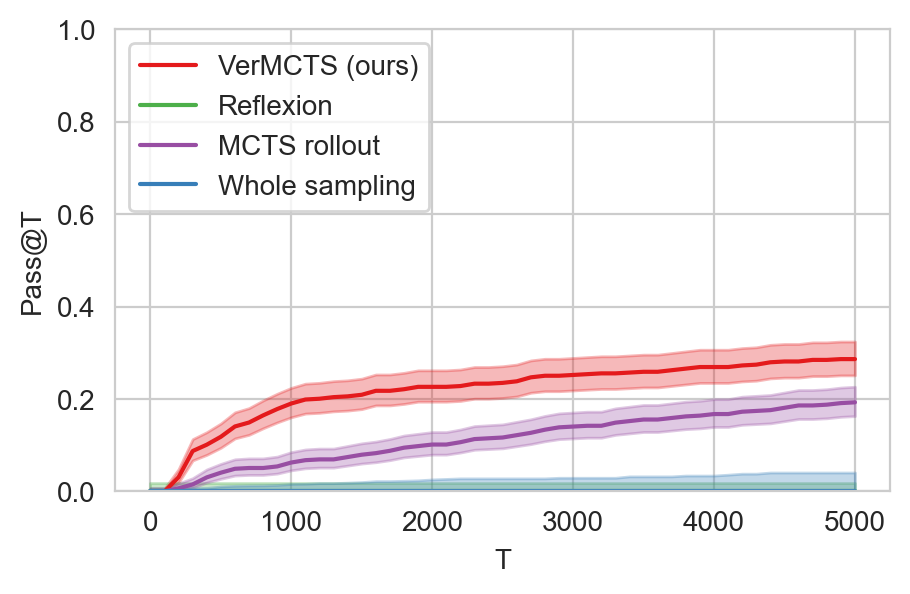

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(5, 3), dpi=200)
sns.set_style("whitegrid")

for alg in alg_names:
    if alg == "whole":
        continue
    select_df = tree_df[tree_df["alg"] == alg]
    plot_pass(select_df, axs)

plot_pass(whole_df, axs)

axs.set_xlabel("T")
axs.set_ylabel("Pass@T")
axs.legend(loc="upper left") # , bbox_to_anchor=(1,1))

# plt.suptitle("Pass@T over T")
plt.show()